In [2]:
import numpy as np
import time
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import collections
import itertools
from sklearn import preprocessing

In [3]:
cd ../../py

/Users/RichardP/research/icyfire/py


In [4]:
import fire_data as dat
import fire_svm as clf
import fire_model as model
import fire_org as org 
import fire_uncertainty as unc

In [5]:
file_read = dat.file_read('/Users/RichardP/research/icyfire/data/sage5.fits')
data = dat.data_to_pytorch(file_read.data[:242])

In [6]:
name_labels = {}
counter = 1
for i in data.name_unique:
    name_labels[i] = counter
    counter += 1
data.relabelling(name_labels)
print(name_labels)

{'RSG': 3, 'OAGB': 2, 'CAGB': 1}


In [7]:
label_carb = org.multistep(data.label)
spectra_oxy, label_oxy = org.deletion(data.spectra, data.label)

In [8]:
#training_carb, testing_carb, train_carb, test_carb, = data.randomization(label_carb, data.spectra, 90)
#training_oxy, testing_oxy, train_oxy, test_oxy, = data.randomization(label_oxy, spectra_oxy, 90)
#training, testing, train, test = data.randomization(data.label, data.spectra, 90)

In [9]:
loss = {}
predictions = {}
errors = {}
correct = {}
source = {}
counts = {}
spec = {}
loss['carb'] = np.array([])
predictions['carb'] = np.array([])
errors['carb'] = np.array([])
correct['carb'] = np.array([])
source['carb'] = np.array([])
counts['carb'] = np.array([])
spec['carb'] = np.array([data.spectra[0]])
loss['oxy'] = np.array([])
predictions['oxy'] = np.array([])
errors['oxy'] = np.array([])
correct['oxy'] = np.array([])
source['oxy'] = np.array([])
counts['oxy'] = np.array([])
spec['oxy'] = np.array([data.spectra[0]])


In [20]:
testing['y'][1]

tensor(2.)

In [10]:
for i in range(0,1000):
    training, testing, train, test = data.randomization(data.label, data.spectra, 90)
    fire = clf.svm_network(training['x'], training['y'], testing['x'], testing['y'], c= 868, gamma = 0.0001, kernel = 'rbf')
    
    loss['carb'] = np.append(loss['carb'], fire.loss.item())
    conf = fire.confidence(testing['x'], testing['y'])
    predictions['carb'] = np.append(predictions['carb'], fire.prediction)
    errors['carb'] = np.append(errors['carb'], fire.predict_error)
    correct['carb'] = np.append(correct['carb'], fire.actual_error)
    predictions['carb'] = np.delete(predictions['carb'], fire.mask)
    source['carb'] = np.append(source['carb'], testing['index'][fire.mask])
    counts['carb'] = np.append(counts['carb'], testing['index'])
    spec['carb'] = np.vstack((spec['carb'], test['x'][fire.mask]))
spec['carb'] = np.delete(spec['carb'], 0, axis = 0)


KeyboardInterrupt: 

In [16]:
grid_carb, acc_carb = org.correct_dispersion(predictions['carb'], integer = True)
#grid_oxy, acc_oxy = org.correct_dispersion(predictions['oxy'], integer = True)

In [17]:
mask_carb, conf_carb = org.error_dispersion(errors['carb'], correct['carb'], predictions['carb'])
#mask_oxy, conf_oxy = org.error_dispersion(errors['oxy'], correct['oxy'], predictions['oxy'])#

In [18]:
#data_carb = scattering(acc_carb, conf_carb)
#data_oxy = scattering(acc_oxy, conf_oxy)

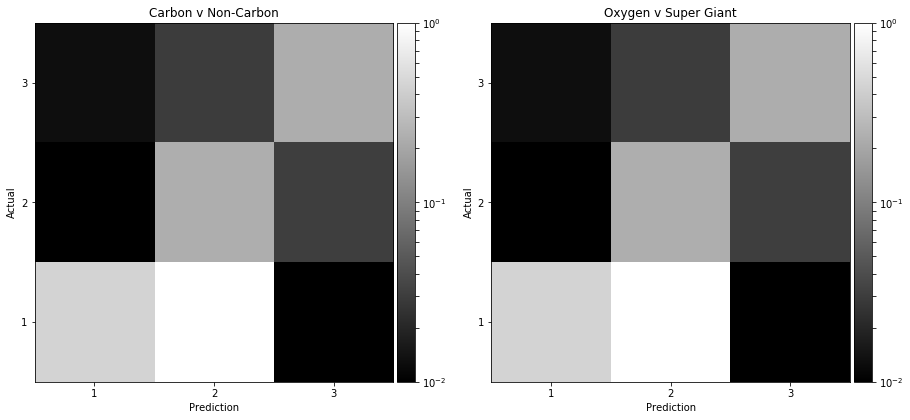

In [19]:
comp = model.comparisons
data1 = comp(conf_carb,acc_carb)
#data2 = comp(conf_oxy,acc_oxy)
#data3 = comp(conf_carb,acc_carb)
#data4 = comp(conf_oxy,acc_oxy)
comp.graph(comp, data1.grid, data1.grid)#, data3.grid, data4.grid)

In [20]:
data1.grid/np.sum(data1.grid) * 100

array([[  1.30416667,   3.00833333,  22.6125    ],
       [  0.85416667,  22.95416667,   3.075     ],
       [ 45.90833333,   0.        ,   0.28333333]])

In [22]:
data2.grid/np.sum(data2.grid) * 100

NameError: name 'data2' is not defined

In [23]:
train_oxy['y'].shape

NameError: name 'train_oxy' is not defined

In [21]:
print(errors['oxy'].shape)
print(errors['carb'].shape)

(0,)
(2046,)


In [ ]:
pop_carb = np.array(collections.Counter(source['carb']).most_common(50))
pop_oxy = np.array(collections.Counter(source['oxy']).most_common(30))

In [ ]:
pop_carb

In [ ]:
misclass_carb = [146.0, 144.0, 61.0,]
for i in range(0,len(pop_carb)):
    if pop_carb[:,1][i]/ np.shape(np.where(counts['carb'] == pop_carb[:,0][i])[0]) > .5:
        x = np.where(source['carb'] == pop_carb[i][0])
        plt.plot(file_read.data['Wave'][x[0][0]], spec['carb'][x[0][0]])
        plt.show()
        misclass_carb.append(pop_carb[i][0])

In [ ]:
misclass_oxy = []
mask_oxy = np.where(np.array(file_read.data['Name']) != '1')
for i in range(0,len(pop_oxy)):
    y = (
        pop_oxy[:,1][i]
        / np.shape(np.where(counts['oxy'] == pop_oxy[:,0][i])[0]))
    if y > .75:
        actual = file_read.data['Name'][mask_oxy[0][int(pop_oxy[:,0][i])]]
        x = np.where(source['oxy'] == pop_oxy[i][0])
        plt.figure(figsize = (15,7))
        label = str(actual) + ' Spectra'
        print([mask_oxy[0][int(pop_oxy[:,0][i])]])
        plt.title(label)
        plt.xlabel('Wavelength (Jansky)')
        plt.ylabel('Flux (Jansky)')
        plt.plot(
            file_read.data['Wave'][x[0][0]], 
            spec['oxy'][x[0][0]])
        plt.show()
        misclass_oxy.append([mask_oxy[0][int(pop_oxy[:,0][i])]])

In [ ]:
print(np.unique(misclass_oxy))

In [ ]:
j = 61
objects = {}
fluxxing = {}
objects[j] = np.zeros([1,1000])
fluxxing[j] = np.zeros([1,1000])
dflux = file_read.data['Dflux'][j]
for i in range(0,364):
    x = np.random.normal(file_read.data['Flux'][j][i], (dflux[i]),1000)
    x = np.reshape(x,(1,1000))
    cha = file_read.data['Flux'][j][i] - x
    fluxxing[j]= np.vstack((fluxxing[j], cha))
    objects[j] = np.vstack((objects[j], x))
#for i in range(300, 364):
#    x = np.random.normal(file_read.data['Flux'][60][i], (dflux[i]/3),1000)
#    x = np.reshape(x,(1,1000))
#    object[60] = np.vstack((object[60], x))
objects[j] = np.delete(objects[j], 0, axis = 0)


In [ ]:
objects[j].shape
print(file_read.data['Name'][j])

In [ ]:
predict = []
for i in range(0,1000):
    x = np.reshape(preprocessing.scale(objects[j][:,i]), (1,364)) + 5
    estim = fire_carb.clf.predict(x)
    predict.append(estim)
np.unique(predict)


In [ ]:
np.where(np.array(predict) < 2)

In [ ]:
j = 61
wave = file_read.data['Wave'][j][:-1]
fig, ax = plt.subplots(2, squeeze = True, figsize=(10,10))
multi = 3
plot_spectra = objects[j]
plot_dflux = fluxxing[j]
std = np.array([])
for i in range(0, 364):
    plot_mean = np.mean(plot_spectra[i])
    plot_std = np.std(plot_dflux[i])
    plot_median = np.median(plot_spectra[i])
    std = np.append(std, plot_std)
    ax[0].scatter(wave[i], plot_mean, c = 'b', s = 5, zorder = 10)
    #ax[0].scatter(wave[i], plot_median, c = 'g')
    ax[0].vlines(
        x = wave[i],
        ymin = plot_mean - (multi * plot_std),
        ymax = plot_mean + (multi * plot_std),
        color = 'r', zorder = 0)
        

ax[1].hist(std, 20)
ax[0].set_title('Spectra with Uncertainty')
ax[0].set_xlabel('Wavelength (microns)')
ax[0].set_ylabel('Flux')
#ax[1].set_xticks('')
#ax[1].set_ylabel('Counts')
plt.show()

In [ ]:
corr = np.where(np.array(predict) == 1)
corr[0].shape

In [ ]:
plt.errorbar(
    file_read.data['Wave'][4], 
    file_read.data['Flux'][4], 
    yerr = file_read.data['Dflux'][4])
plt.show()

In [ ]:
plt.plot(file_read.data['Wave'][61][:-1], preprocessing.scale(file_read.data['Flux'][196][:-1]) + 5)
#plt.plot(file_read.data['Wave'][60][:-1], file_read.data['Dflux'][60][:-1])
plt.show()

In [ ]:
uncertainties = unc.data_uncertainty(file_read.data)
uncertainties.gen_spec(1000)

In [ ]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
def graph(data1, data2): #, data3, data4):
        f, (ax1,ax2) = plt.subplots(1,
                                    2, squeeze = True, figsize=(20,15))

        #This normalizes the data into creating "probability" plots
        data = [data1, data2]
        data1 = data1/np.sum(data1)
        data2 = data2/np.sum(data2)


        #Graphs the first subplot in the top left 
        axis1 = ax1.imshow(
            data1, norm = colors.LogNorm(vmin = 0.01, vmax = 1),
            interpolation = 'nearest', cmap = 'gray')
        ax1.set_title('Predictions vs Actual', fontsize = 30)
        ax1.set_xlabel('Prediction', fontsize = 20)
        ax1.set_ylabel('Actual', fontsize = 20)

        #Graphs the first subplot in the top right 
        axis2 = ax2.imshow(
            data2, norm = colors.LogNorm(vmin = 0.01, vmax = 1),
            interpolation = 'nearest', cmap = 'gray')
        ax2.set_title('OAGB v RSG', fontsize = 30)
        ax2.set_xlabel('Prediction', fontsize = 20)
        ax2.set_ylabel('Actual', fontsize = 20)


        #Adds tick marks with labels to each subplot.
        axes = [ax1, ax2]
        axis = [axis1, axis2]
        for i in axes:
            plt.setp(i, xticks= [0,1,2], xticklabels=['CAGB','OAGB','RSG'],
                     yticks=np.arange(2,-1, -1), yticklabels = ['CAGB','OAGB','RSG'])
        plt.rc('xtick',labelsize=20)
        plt.rc('ytick',labelsize=20)

        plt.show()
graph(data1.grid, data1.grid)

#### 

AttributeError: type object 'Table' has no attribute 'close'

In [ ]:
import os
os.system('say "your program has finished"')

1. Dflux that it chose for each wavelength
2. Histogram + graph
3. Target features 
4. 